# BIRDS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zuko
import torch
import torch.distributions as distributions
import torch.nn as nn
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings

from birds import infer
from birds.models import StochVolSimulator, StochVolPrior
from birds.plotting import plot_posterior

In [3]:
device = "cpu"

## 1. Load simulator model

Here we load the `StochVolSimulator` which we provide as an example of Birds. You can provide your own simulator written in PyTorch as a `torch.nn.Module`.
The model `forward()` method should take a tensor with the parameters of the model. All other parameters should be specified in the `__init__`.
The output of the simulator should be a list of tensors, which will be compared to ground truth data. The idea is that we can return multiple time-series.

In [4]:
model = StochVolSimulator(sigma=0.0, T=100)

## 2. Load ground truth data

Here we create some synthetic data as ground truth. It is important that the structure of the ground truth data matches the output of the simulator.

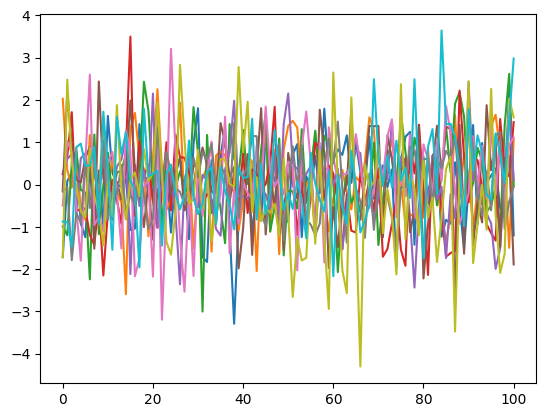

In [5]:
f, ax = plt.subplots()

true_parameters = torch.log(torch.tensor([15., 20.]))

for i in range(10):
    obs_data = model.forward(true_parameters)
    ax.plot(obs_data[0]);

## 3. Specify a prior

We specify a prior. The dimensions of the distribution must be equal to the input parameters.

In [6]:
prior = StochVolPrior()
#prior = torch.distributions.MultivariateNormal(torch.log(torch.tensor([10, 30.])), 1.0 * torch.eye(2))

(array([ 14., 147., 282., 273., 177.,  69.,  19.,  13.,   4.,   2.]),
 array([ 1.70348203,  2.57866335,  3.45384479,  4.32902622,  5.20420742,
         6.07938862,  6.95457029,  7.82975149,  8.70493317,  9.58011436,
        10.45529556]),
 <BarContainer object of 10 artists>)

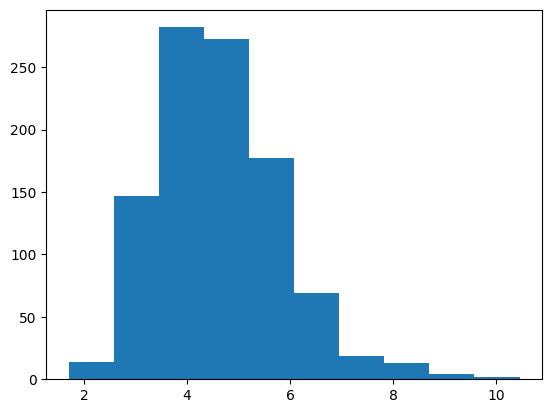

In [7]:
_ = prior.rsample(1000)
plt.hist(torch.exp(_[:, 0]))

## 4. Normalizing Flow

We initialize a [zuko](https://github.com/francois-rozet/zuko) flow. See the zuko docs for more info.

In [8]:
n_params = 2
flow = zuko.flows.NSF(n_params, 1, transforms=5, hidden_features=[50]*3)
# flow = distributions.transformed_distribution.TransformedDistribution(flow, distributions.transforms.ExpTransform())
flow = flow.to(device)

## 5. Run inference

We can then call the `infer` function to run inference on the model with the specified flow.
There are two loss functions available for now: `MSELoss` and `LogMSELoss`. The log version takes the log of the time-series before calculating the mean-square error. This is only suitable for time-series which do not have negatiive values.


In [9]:
#pdist = nn.PairwiseDistance(p=2.)
y = obs_data[0]
y_matrix = y.reshape(1,-1,1)
y_sigma = torch.median(torch.pow(torch.cdist(y_matrix, y_matrix), 2))
ny = y.shape[0]
kyy = (torch.exp( - torch.pow(torch.cdist(y_matrix, y_matrix), 2) / y_sigma ) - torch.eye(ny)).sum() / (ny * (ny - 1))

def mmd_loss(y, x):
    
    """
    Assumes x, y are shape (T, C)
    """
    nx = x.shape[0]
    x_matrix = x.reshape(1,-1,1)
    kxx = torch.exp( - torch.pow(torch.cdist(x_matrix, x_matrix), 2) / y_sigma )
    #kxx = torch.nan_to_num(kxx, 0.)
    kxx = (kxx - torch.eye(nx)).sum() / (nx * (nx - 1))
    kxy = torch.exp( - torch.pow(torch.cdist(x_matrix, y_matrix), 2) / y_sigma )
    #kxy = torch.nan_to_num(kxy, 0.)
    kxy = kxy.mean()
    if torch.isnan(kxy):
        warnings.warn("kxy nan")
    if torch.isnan(kxx):
        warnings.warn("kxx nan")
    return kxx + kyy - 2 * kxy

In [10]:
infer(model=model,
    flow = flow,
    prior = prior,
    obs_data = obs_data,
    n_epochs = 1000,
    n_samples_per_epoch = 5,
    n_samples_regularization = 1000,
    w = 0.001,
    save_dir = "./results",
    learning_rate = 1e-3,
    loss = mmd_loss,
    true_values = true_parameters.cpu().numpy(),
    plot_posteriors = "never",
    device=device,
    lims=[(0, 5), (0, 100)],
    clip_val=1.,
    max_num_epochs_without_improvement=1000
)

Training flow with 1960 parameters


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                         | 198/1000 [00:26<01:47,  7.45it/s, Forecast=0.00593, Reg.=0.0522, total=0.0581]


KeyboardInterrupt: 

## 6. Plot results

The results are saved in the specified `save_dir`. In this case, the `results` folder. Each time a parameter configuration beats the best loss, we save the `.pth` object so we can reload the model later. We also save `loss_data.csv` with the loss values:

<Axes: >

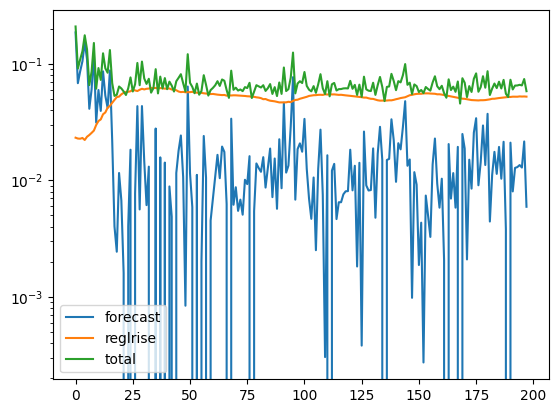

In [11]:
df = pd.read_csv("./results/losses_data.csv")
df.plot(logy=True)

We can load the best model and plot the posterior doing this:

In [16]:
best_model = np.sort(glob("./results/saved_models/model_0020.pth"))[-1]
flow.load_state_dict(torch.load(best_model))

<All keys matched successfully>

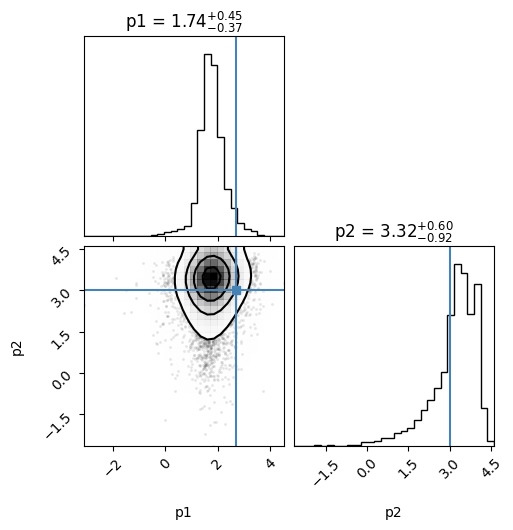

In [17]:
flow_cond = flow(torch.zeros(1))
plot_posterior(flow_cond, param_names=["p1", "p2"], true_values=true_parameters.numpy(), lims = None);

In [18]:
true_parameters

tensor([2.7081, 2.9957])

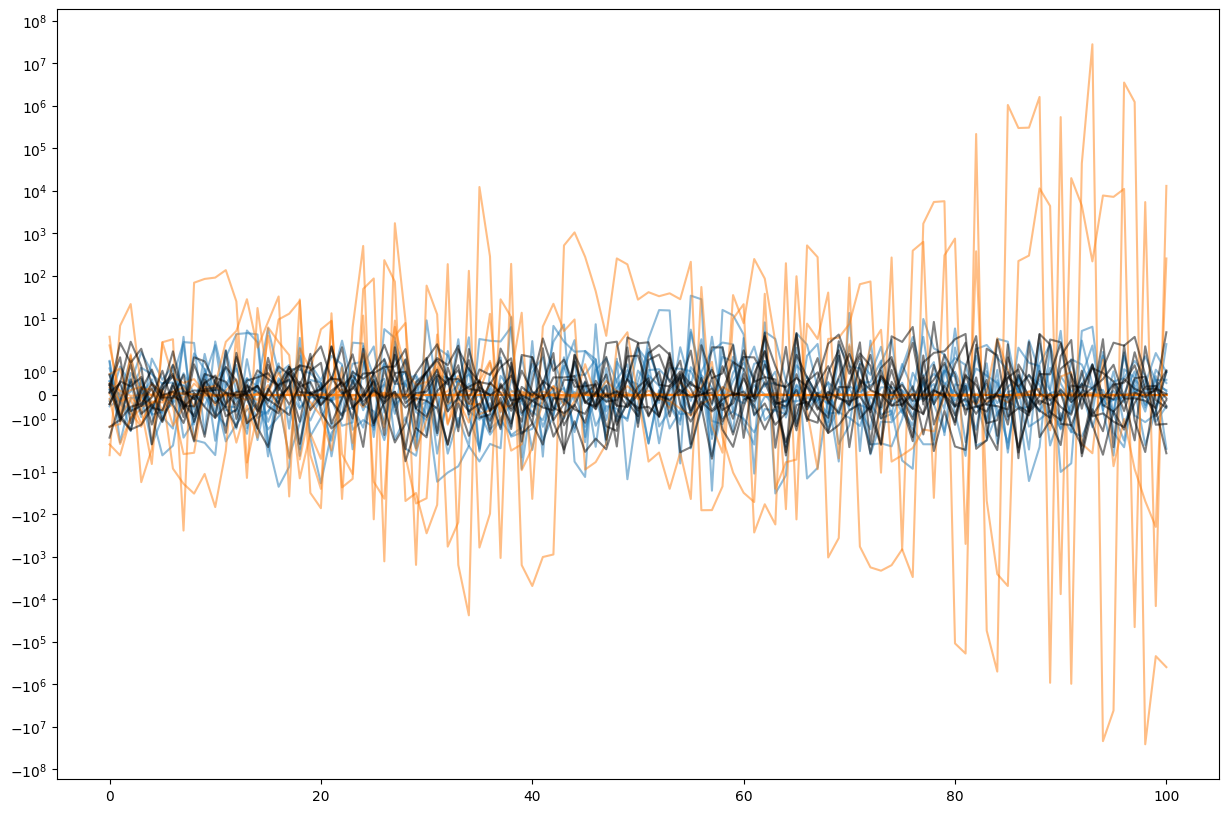

In [19]:
f, ax = plt.subplots(figsize=(15, 10))
#ax.plot(obs_data[0], color = "black");

for i in range(10):
    sample = flow(torch.zeros(1)).sample()
    pred = model(sample)
    ax.plot(pred[0], color = "C0", alpha=0.5)
    
for i in range(10):
    sample = prior.rsample(1)
    pred = model(sample[0])
    ax.plot(pred[0], color = "C1", alpha=0.5)
    
for i in range(10):
    obs_data = model.forward(true_parameters)
    ax.plot(obs_data[0], color = "black", alpha=0.5);
    
ax.set_yscale("symlog")